# Analisis de los precios en 2024



Métricas de Backtest (modelo v2):
 Total Return (%)  Sharpe Ratio  Sortino Ratio  Max Drawdown (%)  Win Rate (%)  Profit Factor  Número de trades  Volatilidad anualizada (%)  Expectativa por trade (%)
        35.688727      3.203516       4.251123        -14.872569     52.812859        1.10539                 6                   51.960282                   0.019002


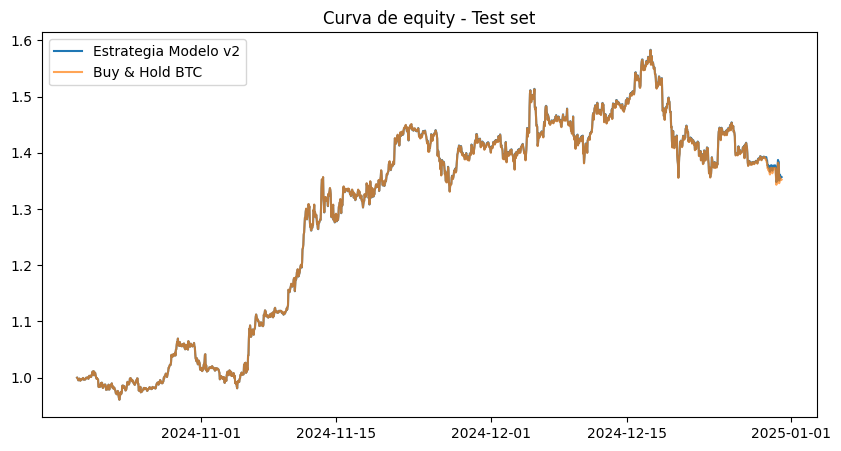

In [3]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import roc_auc_score, precision_recall_curve
import matplotlib.pyplot as plt

# --- Parámetros ---

HORIZON_HOURS = 4
PCT_THRESHOLD = 0.003
OPTIM_GOAL = 'recall'
TEST_SIZE_FRAC = 0.2
N_SPLITS = 5

# --- Funciones de indicadores ---
def macd(series, fast=12, slow=26, signal=9):
    ema_fast = series.ewm(span=fast, adjust=False).mean()
    ema_slow = series.ewm(span=slow, adjust=False).mean()
    macd_line = ema_fast - ema_slow
    signal_line = macd_line.ewm(span=signal, adjust=False).mean()
    return macd_line, signal_line, macd_line - signal_line

def bollinger(series, window=20, num_std=2):
    ma = series.rolling(window).mean()
    std = series.rolling(window).std()
    return ma, ma + num_std * std, ma - num_std * std, (2 * num_std * std) / (ma + 1e-9)

def stochastic_osc(high, low, close, k_window=14, d_window=3):
    lowest_low = low.rolling(k_window).min()
    highest_high = high.rolling(k_window).max()
    k = 100 * (close - lowest_low) / (highest_high - lowest_low + 1e-9)
    return k, k.rolling(d_window).mean()

def rsi(series, window=14):
    delta = series.diff()
    gain = np.where(delta > 0, delta, 0.0)
    loss = np.where(delta < 0, -delta, 0.0)
    roll_up = pd.Series(gain).rolling(window).mean()
    roll_down = pd.Series(loss).rolling(window).mean()
    rs = roll_up / (roll_down + 1e-9)
    return 100 - (100 / (1 + rs))

def add_lags(df, col, lags):
    for l in lags:
        df[f"{col}_lag{l}"] = df[col].shift(l)
    return df

# --- Cargar datos ---
df = pd.read_csv("/Users/guidoboronat/personal/repo trading/personal_investments/personal_investments-1/Trading/Precios BTC/temp_btc_prices.csv")
df['open_time'] = pd.to_datetime(df['open_time'])
df = df.sort_values('open_time').reset_index(drop=True)

close = df['close_price']
high = df['high_price']
low = df['low_price']
openp = df['open_price']
vol = df['volume']
trades = df['num_trades']

# --- Features ---
df['ret_1h'] = close.pct_change()
for w in [3, 6, 12, 24]:
    df[f'ret_{w}h'] = close.pct_change(w)

df['vol_12h'] = close.pct_change().rolling(12).std()
df['vol_24h'] = close.pct_change().rolling(24).std()
df['macd'], df['macd_signal'], df['macd_hist'] = macd(close)
df['bb_ma'], df['bb_up'], df['bb_low'], df['bb_width'] = bollinger(close)
df['stoch_k'], df['stoch_d'] = stochastic_osc(high, low, close)
df['rsi_14'] = rsi(close, 14)
df['hl_range'] = (high - low) / close.shift(1)
df['body'] = (close - openp) / openp
df['upper_shadow'] = (high - np.maximum(openp, close)) / openp
df['lower_shadow'] = (np.minimum(openp, close) - low) / openp
df['vol_chg_1h'] = vol.pct_change()
df['vol_sma_20'] = vol.rolling(20).mean()
df['trades_chg_1h'] = trades.pct_change()

for base in ['ret_1h', 'ret_3h', 'ret_6h', 'vol_chg_1h', 'trades_chg_1h']:
    if base in df.columns:
        add_lags(df, base, [1, 2, 3])

# --- Target ---
future_price = close.shift(-HORIZON_HOURS)
df['future_return'] = (future_price - close) / close
df['target_up'] = (df['future_return'] > PCT_THRESHOLD).astype(int)

feature_cols = [c for c in df.columns if c not in ['symbol','interval','open_time','close_time','future_return','target_up','future_close']]

df_model = df.dropna(subset=feature_cols + ['target_up']).reset_index(drop=True)
X = df_model[feature_cols].values
y = df_model['target_up'].values

split_idx = int(len(df_model) * (1 - TEST_SIZE_FRAC))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# --- Tuning ---
tscv = TimeSeriesSplit(n_splits=N_SPLITS)
best_score, best_params = -np.inf, None
for max_depth in [3, None]:
    for lr in [0.03, 0.06]:
        for iters in [300, 500]:
            scores = []
            for tr_idx, val_idx in tscv.split(X_train):
                Xt, Xv = X_train[tr_idx], X_train[val_idx]
                yt, yv = y_train[tr_idx], y_train[val_idx]
                clf = HistGradientBoostingClassifier(max_depth=max_depth, learning_rate=lr, max_iter=iters, random_state=42)
                clf.fit(Xt, yt)
                yv_prob = clf.predict_proba(Xv)[:, 1]
                scores.append(roc_auc_score(yv, yv_prob))
            if np.mean(scores) > best_score:
                best_score = np.mean(scores)
                best_params = {'max_depth': max_depth, 'learning_rate': lr, 'max_iter': iters}

best_clf = HistGradientBoostingClassifier(**best_params, random_state=42)
best_clf.fit(X_train, y_train)
y_prob_test = best_clf.predict_proba(X_test)[:, 1]

# --- Optimizar umbral ---
precisions, recalls, thresholds = precision_recall_curve(y_test, y_prob_test)
thr = np.r_[0.0, thresholds]
pr_table = pd.DataFrame({'threshold': thr, 'precision': precisions, 'recall': recalls})
if OPTIM_GOAL == 'recall':
    pr_table['f1'] = 2 * (pr_table['precision'] * pr_table['recall']) / (pr_table['precision'] + pr_table['recall'] + 1e-9)
    sel = pr_table.sort_values(['recall','f1','precision'], ascending=[False, False, False]).iloc[0]
best_threshold = float(sel['threshold'])
y_pred_test = (y_prob_test >= best_threshold).astype(int)

# --- Backtest ---
df_test = df_model.iloc[split_idx:].copy()
df_test['signal'] = y_pred_test
df_test['ret_real'] = df_test['close_price'].pct_change().fillna(0)
df_test['ret_strategy'] = df_test['ret_real'] * df_test['signal'].shift(1).fillna(0)
df_test['equity_strategy'] = (1 + df_test['ret_strategy']).cumprod()
df_test['equity_buy_hold'] = (1 + df_test['ret_real']).cumprod()

total_return = df_test['equity_strategy'].iloc[-1] - 1
n_trades = (df_test['signal'].diff().abs() > 0).sum()
win_rate = (df_test.loc[df_test['signal'].shift(1) == 1, 'ret_real'] > 0).mean()
profit_factor = df_test.loc[df_test['ret_strategy'] > 0, 'ret_strategy'].sum() / abs(df_test.loc[df_test['ret_strategy'] < 0, 'ret_strategy'].sum() + 1e-9)
vol_ann = df_test['ret_strategy'].std() * np.sqrt(24*365)
sharpe = df_test['ret_strategy'].mean() / (df_test['ret_strategy'].std() + 1e-9) * np.sqrt(24*365)
neg_std = df_test.loc[df_test['ret_strategy'] < 0, 'ret_strategy'].std()
sortino = df_test['ret_strategy'].mean() / (neg_std + 1e-9) * np.sqrt(24*365)
roll_max = df_test['equity_strategy'].cummax()
drawdown = (df_test['equity_strategy'] / roll_max - 1)
max_dd = drawdown.min()
expectancy = df_test['ret_strategy'].mean()

metrics_bt = {
    "Total Return (%)": total_return * 100,
    "Sharpe Ratio": sharpe,
    "Sortino Ratio": sortino,
    "Max Drawdown (%)": max_dd * 100,
    "Win Rate (%)": win_rate * 100,
    "Profit Factor": profit_factor,
    "Número de trades": int(n_trades),
    "Volatilidad anualizada (%)": vol_ann * 100,
    "Expectativa por trade (%)": expectancy * 100
}
metrics_bt_df = pd.DataFrame([metrics_bt])

print("\nMétricas de Backtest (modelo v2):")
print(metrics_bt_df.to_string(index=False))

# --- Curva de equity ---
plt.figure(figsize=(10,5))
plt.plot(df_test['open_time'], df_test['equity_strategy'], label='Estrategia Modelo v2')
plt.plot(df_test['open_time'], df_test['equity_buy_hold'], label='Buy & Hold BTC', alpha=0.7)
plt.title("Curva de equity - Test set")
plt.legend()
plt.show()
